# Machine Learning Algorithm to learn characteristics of buggy blocks

## Package Imports

In [2]:
import pickle
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from feature_selector import FeatureSelector
import pprint as pp
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_confusion_matrix

## Initializing Variables

In [3]:
# LAVA_GET function address. This function causes a crash.
LAVA_GET_ADDRESS = '001021a0'

In [4]:
# Loading instruction data obtained from Ghidra block analysis.
instr_dict = {}
with open('instr.pkl', 'rb') as f:
    instr_dict = pickle.load(f)

pp.pprint(dict(list(instr_dict.items())[0:3]))

{'001032db\r': ['MOV RBX,qword ptr [RSP + 0x48]\r',
                'MOV R15,qword ptr [RSP + 0x20]\r',
                'JMP 0x001032fc\r'],
 '00104de0\r': ['MOV R9,qword ptr [RBX + 0x38]\r',
                'MOV RAX,qword ptr [RBX + 0x10]\r',
                'LEA RSI,[0x107490]\r',
                'MOV R8,qword ptr [RBX + 0x8]\r',
                'MOV EDX,0x5\r',
                'XOR EDI,EDI\r',
                'MOV R13,qword ptr [RBX + 0x30]\r',
                'MOV R12,qword ptr [RBX + 0x28]\r',
                'MOV qword ptr [RSP + 0x10],R9\r',
                'MOV R15,qword ptr [RBX + 0x20]\r',
                'MOV R14,qword ptr [RBX + 0x18]\r',
                'MOV qword ptr [RSP],RAX\r',
                'MOV qword ptr [RSP + 0x8],R8\r',
                'MOV RBX,qword ptr [RBX]\r',
                'CALL 0x00101740\r',
                'SUB RSP,0x8\r'],
 '001065aa\r': ['LEA EAX,[RDI + -0x9]\r', 'CMP EAX,0x1\r', 'JBE 0x00106591\r']}


## Data Preparation

In [5]:
# Extracting instruction mnenomics from data and getting bug labels
new_instr = {}
bugs_dict = {}
for key, val in instr_dict.items():
    instructions = " ".join(val).replace(","," ")
    found = re.findall("[A-Z][A-Z]+", instructions)
    address = key.replace('\r','')
    new_instr[address] = found
    bugs_dict[address] = int(any(LAVA_GET_ADDRESS in s for s in val))

In [6]:
# Converting bug dict to pandas dataframe
bugs_df = pd.DataFrame([(key, var) for key, var in bugs_dict.items()], 
                 columns=['address', 'bug_flag'])

pd.DataFrame.describe(bugs_df)

,bug_flag
count,884.000000
mean,0.108597
std,0.311309
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [7]:
# Converting dict of addresses and instructions into normalized pandas dataframe
instr_df = pd.DataFrame([(key, var) for (key, L) in new_instr.items() for var in L], 
                 columns=['address', 'instruction'])

instr_df.head()

,address,instruction
0,001065aa,LEA
1,001065aa,EAX
2,001065aa,RDI
3,001065aa,CMP
4,001065aa,EAX


In [8]:
# Pivoting instructions dataframe into instruction counts
instr_pivt = instr_df.groupby('address')['instruction'].value_counts().unstack().fillna(value=0)
pd.DataFrame.describe(instr_pivt)

instruction,ADD,AL,AND,AX,BL,BPL,BSWAP,BT,CALL,CL,...,SETA,SETNZ,SETZ,SHL,SHR,SIL,SUB,TEST,XMM,XOR
count,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,...,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000
mean,0.179864,0.183258,0.038462,0.001131,0.010181,0.011312,0.001131,0.002262,0.513575,0.013575,...,0.003394,0.011312,0.062217,0.015837,0.023756,0.005656,0.090498,0.184389,0.015837,0.208145
std,0.426210,0.565437,0.239602,0.033634,0.100443,0.142327,0.033634,0.047538,0.965332,0.142129,...,0.058189,0.105815,0.241686,0.133675,0.179660,0.121204,0.320603,0.407940,0.292949,0.612905
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.000000,4.000000,4.000000,1.000000,1.000000,2.000000,1.000000,1.000000,14.000000,2.000000,...,1.000000,1.000000,1.000000,2.000000,3.000000,3.000000,3.000000,3.000000,6.000000,8.000000


In [9]:
#Displaying contents of pivoted instruction dataframe
instr_pivt.head()

instruction,ADD,AL,AND,AX,BL,BPL,BSWAP,BT,CALL,CL,...,SETA,SETNZ,SETZ,SHL,SHR,SIL,SUB,TEST,XMM,XOR
address,,,,,,,,,,,,,,,,,,,,,
00101650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
00101660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00101662,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00101830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001018c0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Feature Selection

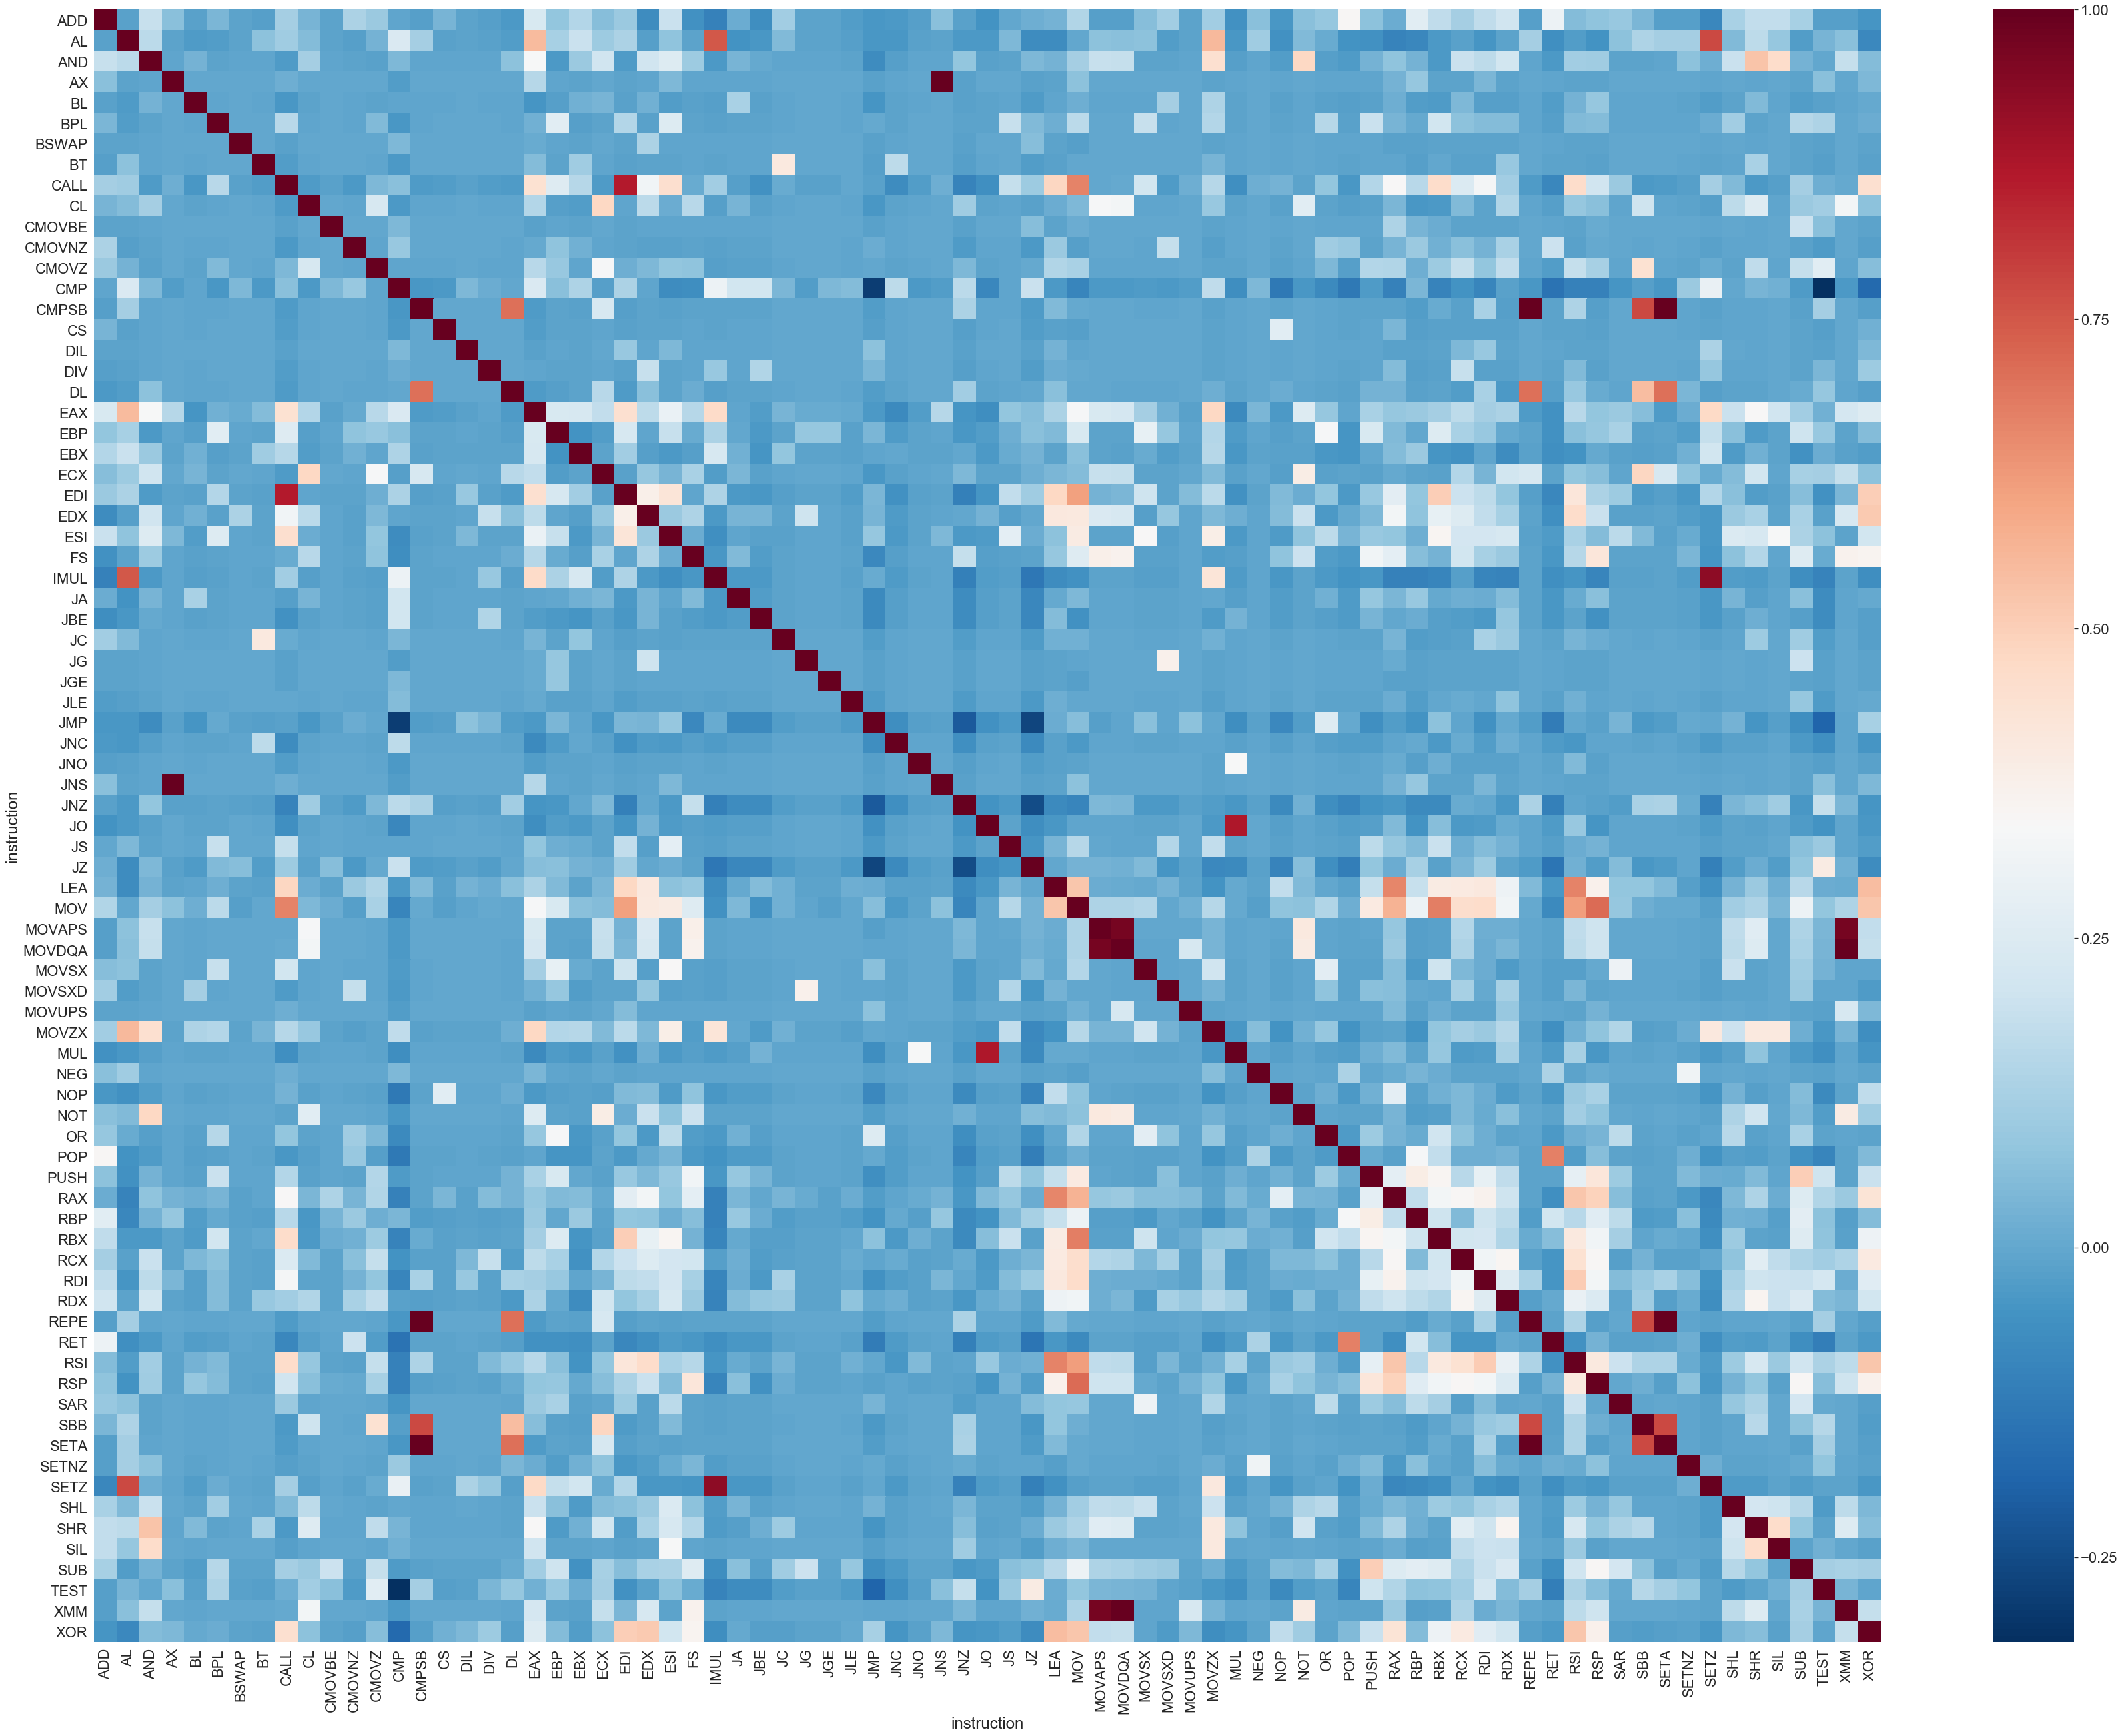

In [10]:
# Display heatmap of pearson correlations
pearsoncorr = instr_pivt.corr(method='pearson')
plt.figure(figsize = (60,45))
sb.set(font_scale=2)
sb.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=False)

In [11]:
#Merging bug labels onto instructions dataframe
labeled_df = instr_pivt.merge(bugs_df, on='address')

labeled_df['bug_flag'].head()

0    0
1    0
2    0
3    0
4    0
Name: bug_flag, dtype: int64

8 features with a correlation magnitude greater than 0.80.



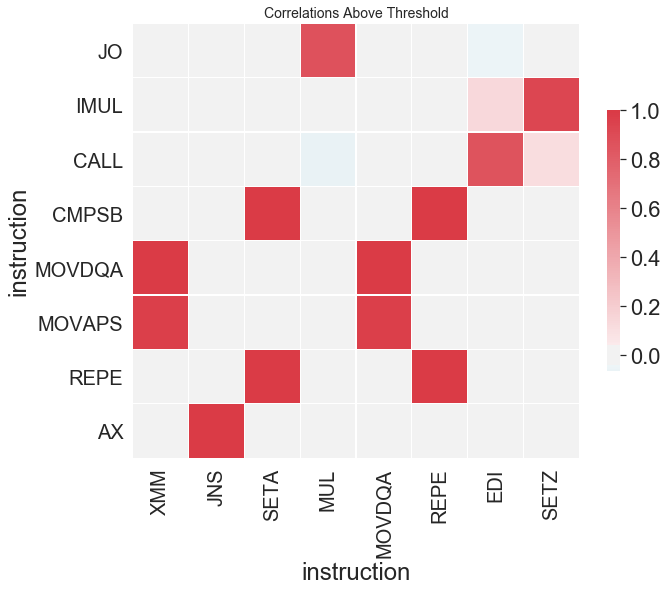

In [12]:
#Initializing FeatureSelector package
fs = FeatureSelector(data = instr_pivt, labels = labeled_df['bug_flag'])

#Identifying collinear features
fs.identify_collinear(correlation_threshold = 0.8)

#Plotting collinear features
fs.plot_collinear()

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[10]	valid_0's auc: 1	valid_0's binary_logloss: 0.158317
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[78]	valid_0's auc: 1	valid_0's binary_logloss: 0.0291043
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[7]	valid_0's auc: 1	valid_0's binary_logloss: 0.183067
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[11]	valid_0's auc: 1	valid_0's binary_logloss: 0.14577
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[9]	valid_0's auc: 1	valid_0's binary_logloss: 0.162719
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[31]	valid_0's auc: 0.9988	valid_0's binary_logloss: 0.0580672
Training until validation scores don't

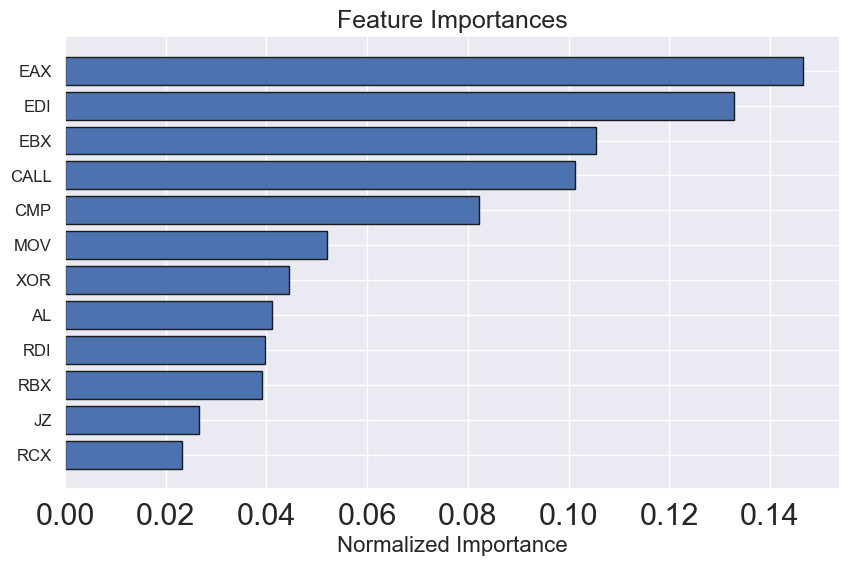

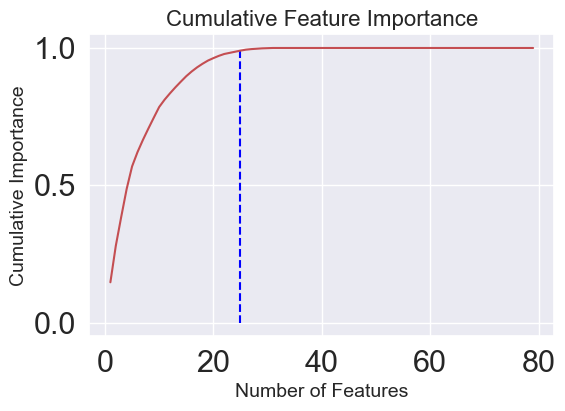

25 features required for 0.99 of cumulative importance


In [13]:
# Identify zero importance features
fs.identify_zero_importance(task = 'classification', 
                            eval_metric = 'auc', 
                            n_iterations = 10, 
                             early_stopping = True)
# list of zero importance features
zero_importance_features = fs.ops['zero_importance']

# plot the feature importances
fs.plot_feature_importances(threshold = 0.99, plot_n = 12)

In [14]:
# Identify low importance features
fs.identify_low_importance(cumulative_importance = 0.99)

24 features required for cumulative importance of 0.99 after one hot encoding.
55 features do not contribute to cumulative importance of 0.99.



In [15]:
# Display top 10 important features
fs.feature_importances.head(10)

,feature,importance,normalized_importance,cumulative_importance
0,EAX,21.4,0.146575,0.146575
1,EDI,19.4,0.132877,0.279452
2,EBX,15.4,0.105479,0.384932
3,CALL,14.8,0.101370,0.486301
4,CMP,12.0,0.082192,0.568493
5,MOV,7.6,0.052055,0.620548
6,XOR,6.5,0.044521,0.665068
7,AL,6.0,0.041096,0.706164
8,RDI,5.8,0.039726,0.745890
9,RBX,5.7,0.039041,0.784932


In [16]:
# Remove the features from all methods (returns a df)
train_removed = fs.remove(methods = 'all')

['collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 56 features.


In [17]:
# Display training data with features removed
train_removed.head()

instruction,ADD,AL,CALL,CMP,EAX,EBP,EBX,EDX,ESI,IMUL,...,MOVZX,RAX,RBP,RBX,RCX,RDI,RSI,RSP,TEST,XOR
address,,,,,,,,,,,,,,,,,,,,,
00101650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
00101660,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00101662,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
00101830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001018c0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Analyze class imbalance
labeled_train = train_removed.merge(bugs_df, on='address')
labeled_train.groupby('bug_flag').mean()

,ADD,AL,CALL,CMP,EAX,EBP,EBX,EDX,ESI,IMUL,...,MOVZX,RAX,RBP,RBX,RCX,RDI,RSI,RSP,TEST,XOR
bug_flag,,,,,,,,,,,,,,,,,,,,,
0,0.167513,0.083756,0.389594,0.281726,0.422589,0.062183,0.065990,0.130711,0.178934,0.002538,...,0.098985,0.790609,0.277919,0.531726,0.213198,0.270305,0.248731,0.686548,0.206853,0.233503
1,0.281250,1.000000,1.531250,1.000000,2.520833,0.291667,0.541667,0.000000,0.031250,0.500000,...,0.500000,0.104167,0.364583,0.270833,0.000000,0.020833,0.000000,0.083333,0.000000,0.000000


## Model Training

In [19]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train_removed, labeled_df['bug_flag'], test_size=0.3, random_state=0)

In [20]:
# Train logistic regression model and get accuracy
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 1.00


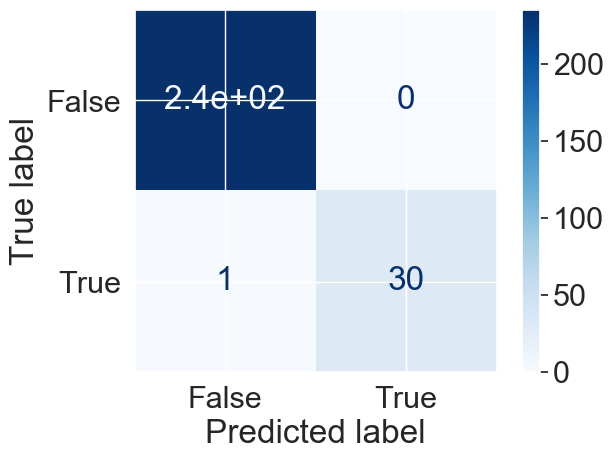

In [21]:
plot_confusion_matrix(logreg, X_test, y_test, display_labels=["False", "True"], cmap=plt.cm.Blues, values_format='%d')

In [22]:
# Display classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       235
           1       1.00      0.97      0.98        31

    accuracy                           1.00       266
   macro avg       1.00      0.98      0.99       266
weighted avg       1.00      1.00      1.00       266



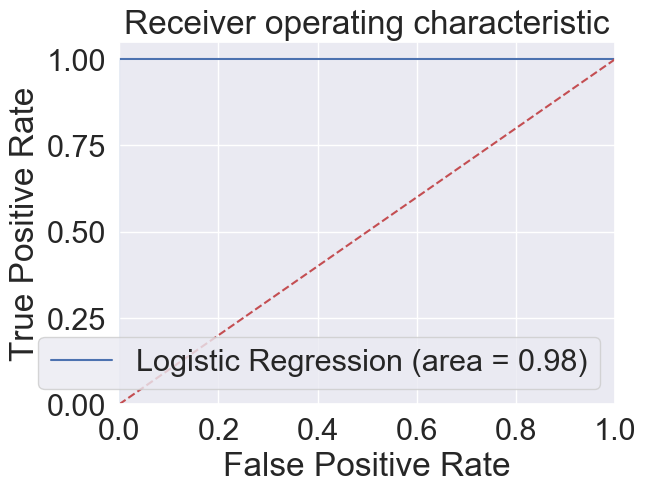

In [23]:
# Display ROC curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [24]:
# labeled_train.groupby('bug_flag')['EBX'].hist(normed = True)

In [25]:
# Display importance of instructions in descending order
pp.pprint((np.std(X_train, 0)*logreg.coef_[0]).sort_values(ascending=False))

instruction
CALL     2.328995
MOV      1.125943
EAX      0.951721
CMP      0.845027
AL       0.493733
JZ       0.328720
IMUL     0.315354
EBP      0.219984
EBX      0.187953
RBP      0.147935
LEA      0.006829
ADD     -0.004571
MOVZX   -0.039351
EDX     -0.351379
RCX     -0.390227
TEST    -0.404430
XOR     -0.541597
RDI     -0.599843
RSI     -0.712463
ESI     -1.001344
RSP     -1.082787
RBX     -1.473938
RAX     -1.843249
dtype: float64
